In [4]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from tensorflow import keras
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from utils.dataset import load_dataset_v2, create_lstm_dataset

In [6]:
file_name_list = os.listdir(os.path.join('data', 'ver_2'))
file_path_list = []

for file_name in file_name_list:
    file_path_list.append(os.path.join('data', 'ver_2', file_name))
    
dataset= load_dataset_v2(file_path_list)

dataset = dataset[dataset['outlet_flowrate(lpm)'] > 1]
dataset.reset_index(drop=True, inplace=True)

dataset = dataset[::10]
dataset.reset_index(drop=True, inplace=True)

extra_column_name_list = ['pressure_1(bar)', 'main_pressure(bar)']
extra_feature = pd.DataFrame()

for col_name in extra_column_name_list:
    extra_feature['grad_'+col_name] = np.gradient(dataset[col_name].to_numpy())

dataset = pd.concat([dataset, extra_feature], axis=1)

dataset_value = dataset.drop(columns=['reserved', 'time(s)', 'test_case', 'test_case_iter'])
dataset_value = pd.concat([dataset_value, extra_feature], axis=1)

feature_col_name_list = ['pressure_1(bar)', 'main_pressure(bar)', 'grad_pressure_1(bar)', 'grad_main_pressure(bar)']
target_col_name = 'outlet_flowrate(lpm)'

train_data = dataset[dataset['test_case_iter']!=3]
val_data = dataset[dataset['test_case_iter']==3]

train_feature = train_data[feature_col_name_list]
train_feature.reset_index(drop=True, inplace=True)

train_target = pd.DataFrame(train_data[target_col_name])
train_target.reset_index(drop=True, inplace=True)

val_feature = val_data[feature_col_name_list]
val_feature.reset_index(drop=True, inplace=True)

val_target = pd.DataFrame(val_data[target_col_name])
val_target.reset_index(drop=True, inplace=True)

loading dataset...:   0%|          | 0/84 [00:00<?, ?it/s]

<AxesSubplot:>

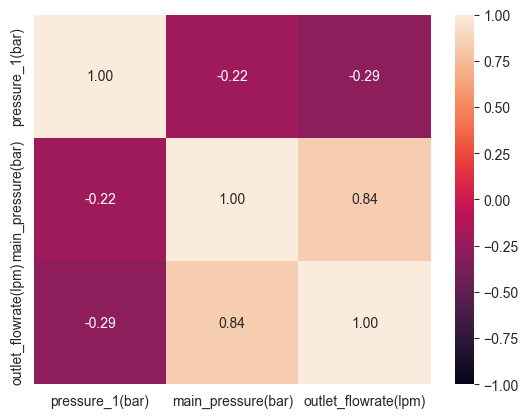

In [10]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[['pressure_1(bar)', 'main_pressure(bar)', 'outlet_flowrate(lpm)']]
sns.heatmap(val_data_slice.corr(), annot=True, fmt='.2f', vmax=1, vmin=-1)


<AxesSubplot:>

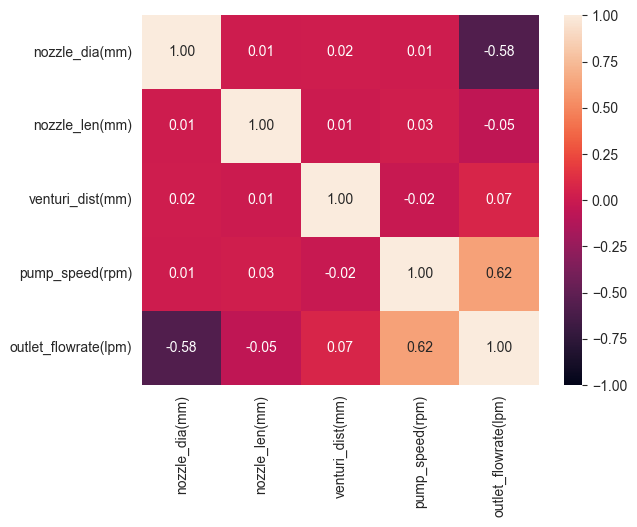

In [11]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[['nozzle_dia(mm)', 'nozzle_len(mm)', 'venturi_dist(mm)', 'pump_speed(rpm)', 'outlet_flowrate(lpm)']]
sns.heatmap(val_data_slice.corr(), annot=True, fmt='.2f', vmax=1, vmin=-1)


In [7]:
seq_len = 30
pred_distance = 0

train_feature_lstm, train_target = create_lstm_dataset(train_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)
val_feature_lstm, val_target = create_lstm_dataset(val_data[feature_col_name_list+[target_col_name]].to_numpy(), seq_len=seq_len, pred_distance=pred_distance, target_idx_pos=4)

In [8]:
best_lstm_model = keras.models.load_model('lstm_model.keras')

In [9]:
train_pred = np.squeeze(best_lstm_model.predict(train_feature_lstm, verbose=1))
val_pred = np.squeeze(best_lstm_model.predict(val_feature_lstm, verbose=1))

2000/2000 [==============================] - 50s 25ms/step


In [10]:
print(r2_score(train_target, train_pred), mean_absolute_error(train_target, train_pred), mean_absolute_percentage_error(train_target, train_pred))

0.9601764233069798 67.3904107599724 0.19359642094893917


In [11]:
print(r2_score(val_target, val_pred), mean_absolute_error(val_target, val_pred), mean_absolute_percentage_error(val_target, val_pred))

0.9487210972990684 76.7396908115325 0.2366921622228741


In [14]:
val_data_slice = val_data.copy()
val_data_slice = val_data_slice[29:]
val_data_slice['abs_error'] = np.abs(val_target-val_pred)
val_data_slice['relative_error'] = (np.abs(val_target-val_pred)/val_target)*100

In [15]:
pump_speed_1_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 850) & (val_data_slice['pump_speed(rpm)'] < 950)]
pump_speed_1_df.reset_index(drop=True, inplace=True)
pump_speed_1_df_fix = pump_speed_1_df.copy()
pump_speed_1_df_fix['pump_speed(rpm)'] = 900

pump_speed_2_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 1150) & (val_data_slice['pump_speed(rpm)'] < 1250)]
pump_speed_2_df.reset_index(drop=True, inplace=True)
pump_speed_2_df_fix = pump_speed_2_df.copy()
pump_speed_2_df_fix['pump_speed(rpm)'] = 1200

pump_speed_3_df = val_data_slice[(val_data_slice['pump_speed(rpm)'] > 1450) & (val_data_slice['pump_speed(rpm)'] < 1550)]
pump_speed_3_df.reset_index(drop=True, inplace=True)
pump_speed_3_df_fix = pump_speed_3_df.copy()
pump_speed_3_df_fix['pump_speed(rpm)'] = 1500

pump_speed_df = pd.concat([pump_speed_1_df_fix, pump_speed_2_df_fix, pump_speed_3_df_fix])


Text(0, 0.5, 'Relative Error(%)')

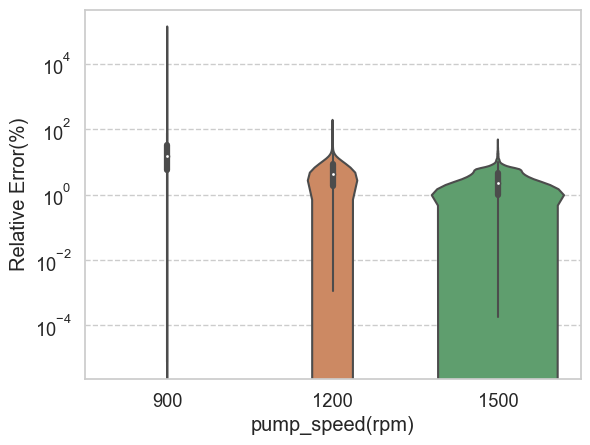

In [49]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=pump_speed_df, x='pump_speed(rpm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

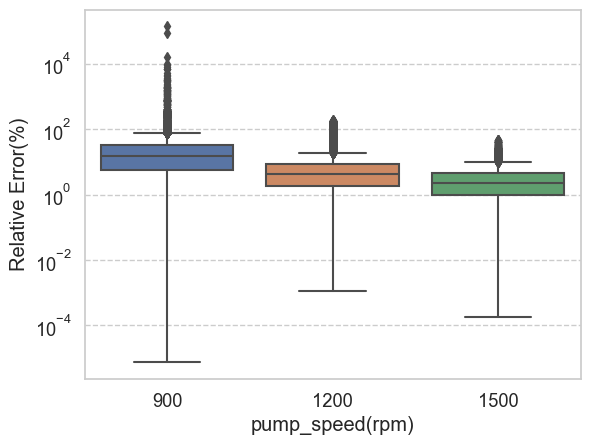

In [18]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=pump_speed_df, x='pump_speed(rpm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

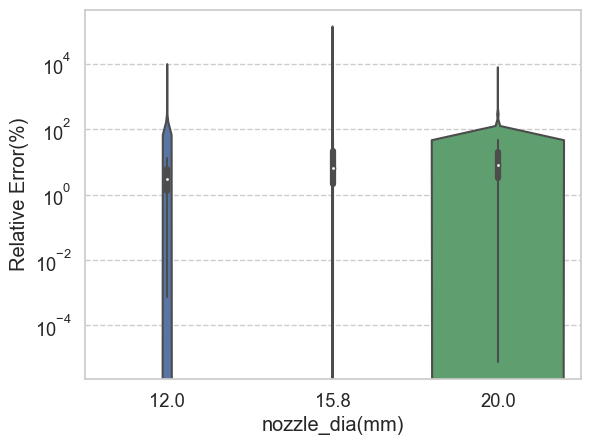

In [48]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='nozzle_dia(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

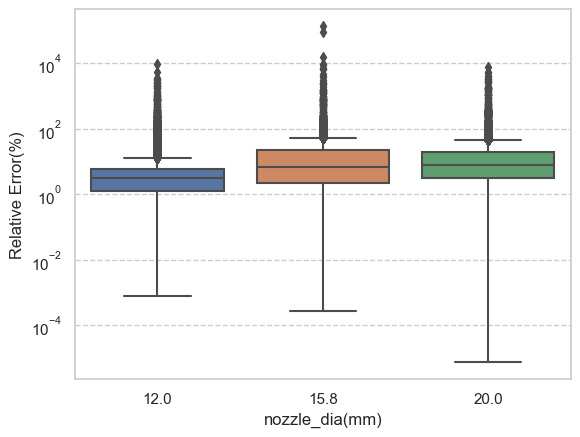

In [19]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='nozzle_dia(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

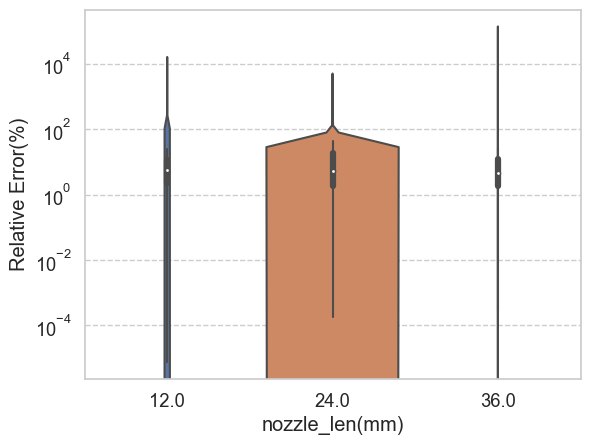

In [47]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='nozzle_len(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

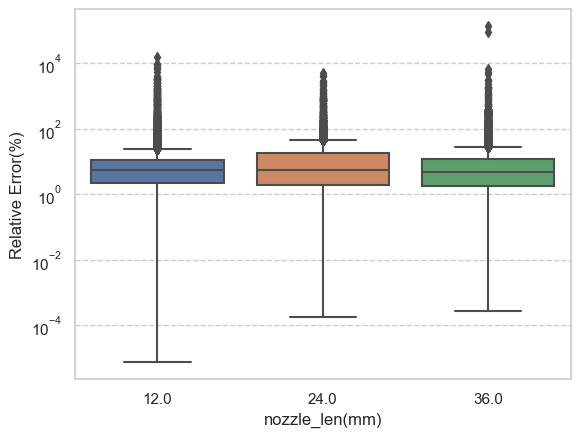

In [20]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='nozzle_len(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

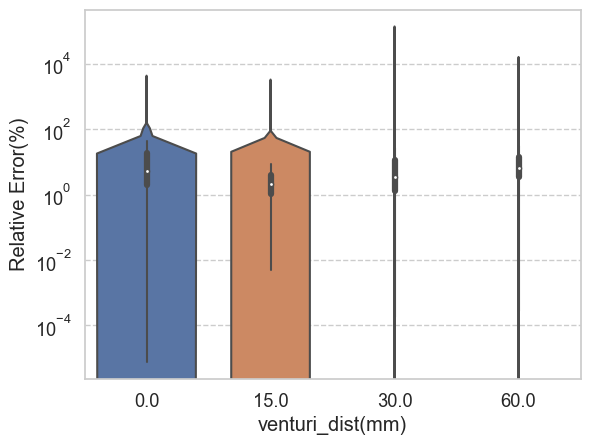

In [46]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.violinplot(data=val_data_slice, x='venturi_dist(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

Text(0, 0.5, 'Relative Error(%)')

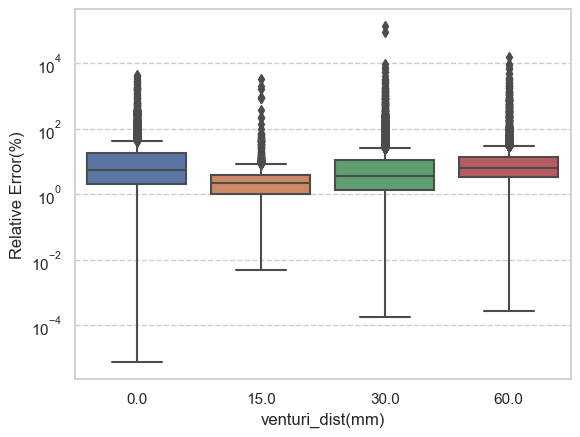

In [21]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.boxplot(data=val_data_slice, x='venturi_dist(mm)', y='relative_error')

plt.yscale('log')
plt.ylabel('Relative Error(%)')

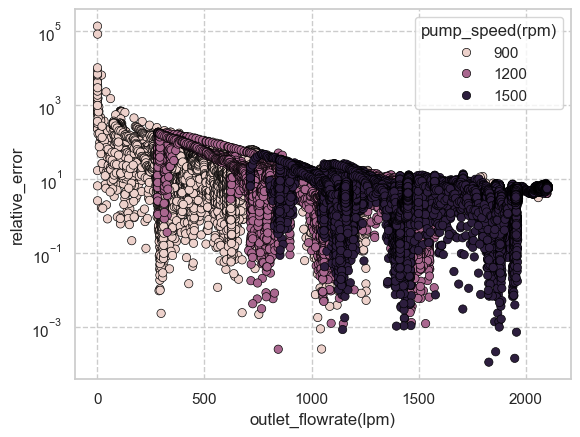

In [88]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=pump_speed_df, x='outlet_flowrate(lpm)', y='relative_error', hue='pump_speed(rpm)', edgecolor='black')

plt.yscale('log')

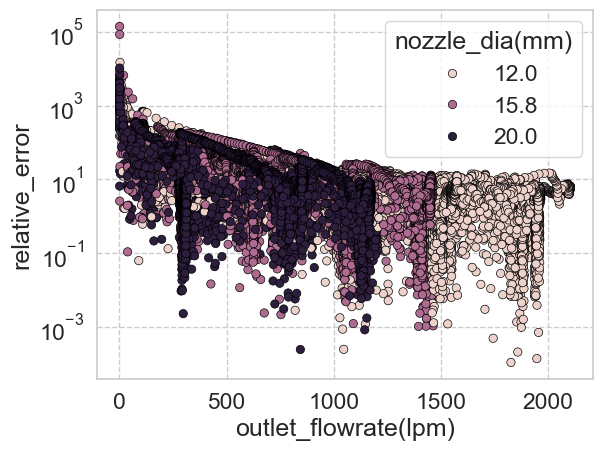

In [36]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='nozzle_dia(mm)',  edgecolor='black')

plt.yscale('log')

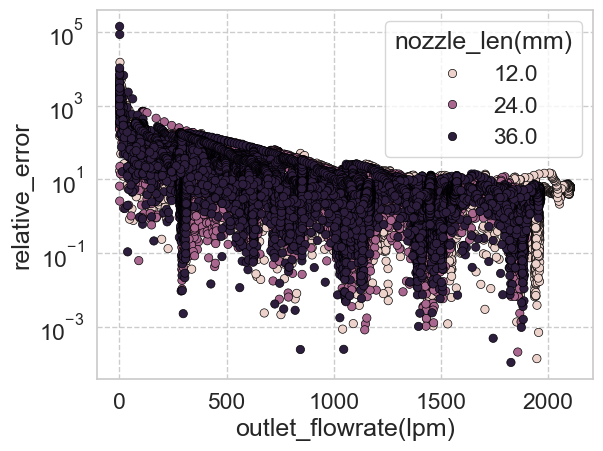

In [37]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='nozzle_len(mm)', edgecolor='black')

plt.yscale('log')

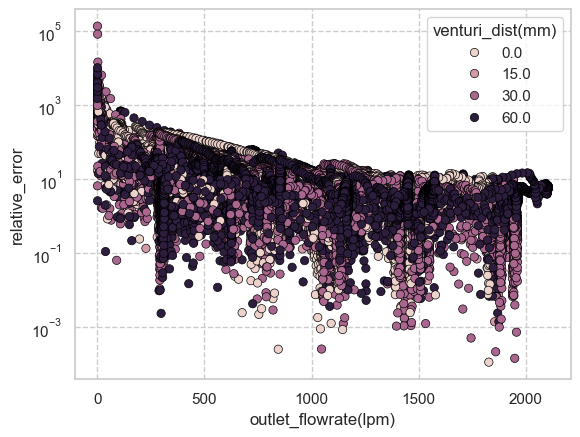

In [39]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(data=val_data_slice, x='outlet_flowrate(lpm)', y='relative_error', hue='venturi_dist(mm)', edgecolor='black')

plt.yscale('log')

Text(0.5, 0, 'Absolute Error(lpm)')

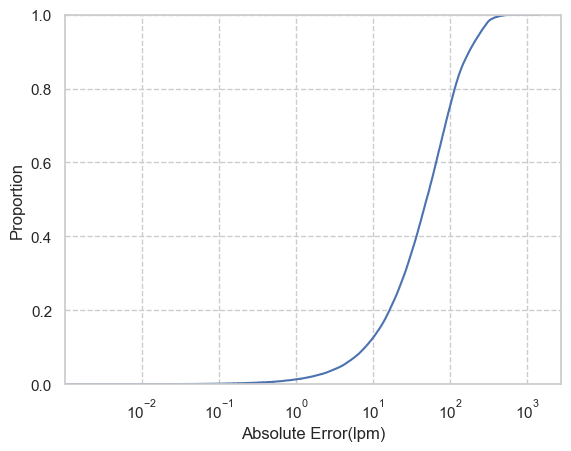

In [97]:
sns.ecdfplot(val_data_slice['abs_error'])
plt.xscale('log')
plt.xlabel('Absolute Error(lpm)')

Text(0.5, 0, 'Relative Error(%)')

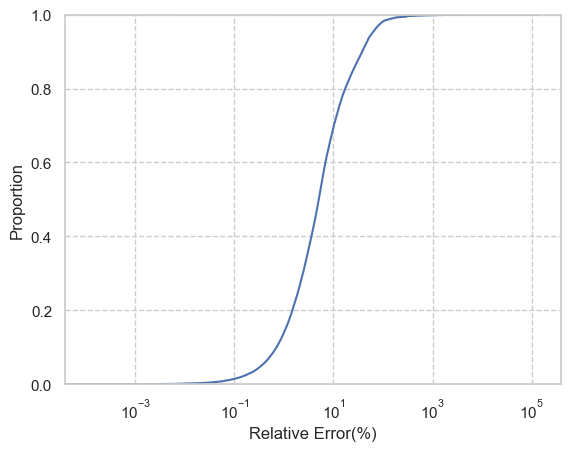

In [98]:
sns.ecdfplot(val_data_slice['relative_error'])
plt.xscale('log')
plt.xlabel('Relative Error(%)')